# Constructing Free-Text Model to Predict Utilization Rate (Recovered Boolean)

In [2]:
# load general modules
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import time

# for visuals
import matplotlib.pyplot as plt
import seaborn as sns

# for preprocessing text
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


nltk.data.path.append('/opt/anaconda3/lib/python3.8/site-packages/nltk')
nlp = spacy.load("en_core_web_sm")

# for model costruction & evaluation
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.utils import shuffle


from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# load in data
data = pd.read_csv("NEW_cleaned_data.csv")
data.head()

,Unnamed: 0,ac,dh,hr,in,li,lk,ll,pa,rk,...,recipient_status,recipient_status_date,recovery_date,transplant_date,recipient_cod,donor_cod,recipient_age,recipient_ethnicity,meld_peld,died_after_transplant
0,0,"27yr female. Smoked some ""spice' about 30mins ...",****PT CDC High risk due to sex in exchange fo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D,10/23/2019,2013-01-28,2013-01-29,4635.0,1.0,52.0,1.0,36.0,2458.0
1,1,Pt was found unresponsive in the road with sig...,ME has restricted all thoracics and nothing ab...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,31 year old male victim of a drive by shooting...,***OR set for 0200***On site coordinator: Kath...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,A,12/30/2020,2013-01-29,2013-01-29,NaN,3.0,50.0,5.0,8.0,NaN
3,3,Pt is 41 yo AA/M with history of ALS (in a whe...,Extubated 1944/ TOD 1947/ Incision 1952/ Perfu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,51 y.o. female with a past medical history of ...,FBO: Lane Aviation. Airport: Port Columbus Int...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D,02/24/2018,2013-01-28,2013-01-29,998.0,2.0,55.0,1.0,18.0,1852.0


In [3]:
for x in data.columns[1:15]:
    print("Number Null {}: ".format(x), data[x].isnull().sum()/data.shape[0])

Number Null ac:  0.0007647671761927978
Number Null dh:  0.026891125832879254
Number Null hr:  0.8704388807632376
Number Null in:  0.9800204575219632
Number Null li:  0.8623419082852964
Number Null lk:  0.6921907711721013
Number Null ll:  0.9246321947861997
Number Null pa:  0.946437618897397
Number Null rk:  0.6951160056210387
Number Null rl:  0.9311135966044337
Number Null sh:  0.07454568049939296
Number Null tr:  0.40008794822526217
Number Null ts:  0.9567715353657021
Number Null vs:  0.8321718431844906


In [4]:
# print(data['utilization_boolean'].isnull().sum()) # no null values
print(data.utilization_boolean.value_counts())
print(data.utilization_boolean.value_counts(normalize=True))

1    83558
0    21049
Name: utilization_boolean, dtype: int64
1    0.79878
0    0.20122
Name: utilization_boolean, dtype: float64


### Define a function to grab different attributes and perform text pre-processing

In [5]:
from nltk.corpus import stopwords
stop = stopwords.words('english') # get list of stopwords

def select_attributes(df, don_text_vars, diag=False, stem=True, lemma=False,file_save=None):
    
    # filter to selected attributes
    if diag==True:
        don_text_vars = don_text_vars + ["diag_txt"]
    temp = df[["utilization_boolean"]+don_text_vars]
    
    # combine attributes into a list
    temp["text"] = temp.apply(lambda x: str([x[i] for i in temp.columns[1:] if x[i] is not np.NaN]),axis=1)
    temp.drop(don_text_vars,axis=1, inplace=True)
    
    # remove stop words, lowercase
    temp['new_col']=temp["text"].apply(lambda x: \
                        ' '.join([word for word in x.lower().split() if word not in (stop)]))
    # remove punctuation
    temp["new_text"] = temp['new_col'].str.replace('[^\sa-z]','')
    temp.drop(["text","new_col"], axis=1, inplace=True)
    
    # stem or lemmatize depending on input
    if stem == True:
        print("Currently Stemming...")
        temp["text"] = temp["new_text"].apply(\
                            lambda x: [PorterStemmer().stem(w) for w in word_tokenize(x)])
        temp = temp.drop(["new_text"],axis=1)
    elif lemma == True:
        print("Currently Lemmatizing...")
        temp["text"] = temp["new_text"].apply(\
                            lambda x: [WordNetLemmatizer().lemmatize(w) for w in word_tokenize(x)])
    temp["text"] = temp["text"].apply(lambda x: " ".join(x))

    # save file if interested
    if file_save is not None:
        temp.to_csv(file_save)
    print("Preprocessing Complete.")
    return temp

In [63]:
ac_sh_li_tr = select_attributes(["ac", "sh", "li","tr"])

Loading Stemmer...


,utilization_boolean,text
0,1,yr femal smoke spice min onset seizur becam un...
1,1,pt found unrespons road sign head trauma repor...
2,1,year old male victim drive shoot sustain gsw h...
3,0,pt yo aam histori al in wheelchair home htn pt...
4,1,yo femal past medic histori alcohol opiat coca...
...,...,...
104602,1,pt yaaf complain headach vomit pt state headac...
104603,0,year old caucasian femal histori dm bipolar di...
104604,1,yo femal transfer higher level care patient ea...
104605,0,patient live nurs facil due difficulti ambul f...


In [73]:
from itertools import combinations

# make a list of all combinations of text fields
combos = []
for i in range(1, len(data.columns[1:15])):
    for item in list(combinations(data.columns[1:15], i)):
        combos.append(item)

# Model Building - Sklearn

### Multinomial Naive Bayes for Every Text Field Individually
This was used to determine which text fields would be useful (used to cut down our feature space)

---------- ac ----------
Currently Stemming...
Preprocessing Complete.
68220
[[3294 2026]
 [1715 3490]] 

Accuracy: 0.6445605700712589
Cohen Kappa score: 0.289495103169219
Sensitivity/Recall: 0.671
Specificity: 0.619
Precision 0.633
F1 Score: 0.6510586699001958


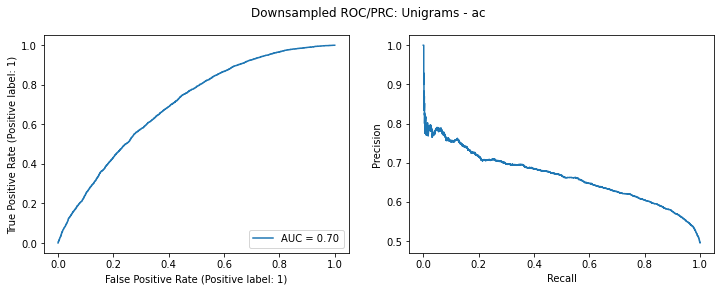

---------- dh ----------
Currently Stemming...
Preprocessing Complete.
65948
[[3221 2099]
 [1411 3794]] 

Accuracy: 0.6665083135391924
Cohen Kappa score: 0.3338886252369262
Sensitivity/Recall: 0.729
Specificity: 0.605
Precision 0.644
F1 Score: 0.6837267976211929


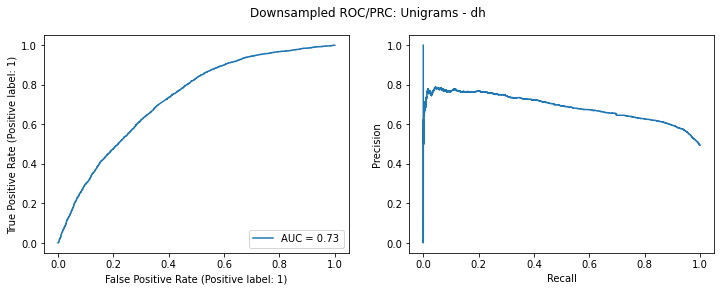

---------- hr ----------
Currently Stemming...
Preprocessing Complete.
5081
[[ 178 5142]
 [ 153 5052]] 

Accuracy: 0.4969121140142518
Cohen Kappa score: 0.004022165337159156
Sensitivity/Recall: 0.971
Specificity: 0.033
Precision 0.496
F1 Score: 0.6561465030196767


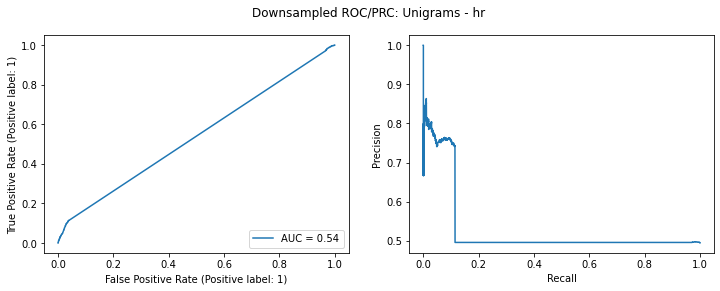

---------- in ----------
Currently Stemming...
Preprocessing Complete.
521
[[  43 5277]
 [  35 5170]] 

Accuracy: 0.4952969121140143
Cohen Kappa score: 0.0013437760732836201
Sensitivity/Recall: 0.993
Specificity: 0.008
Precision 0.495
F1 Score: 0.6606184513161257


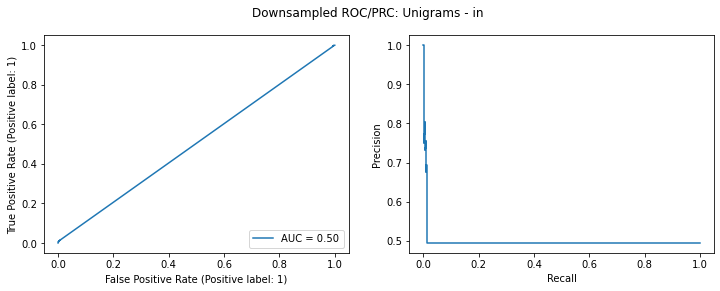

---------- li ----------
Currently Stemming...
Preprocessing Complete.
3468
[[ 384 4936]
 [ 125 5080]] 

Accuracy: 0.5191448931116389
Cohen Kappa score: 0.047688665655423734
Sensitivity/Recall: 0.976
Specificity: 0.072
Precision 0.507
F1 Score: 0.6674988502726495


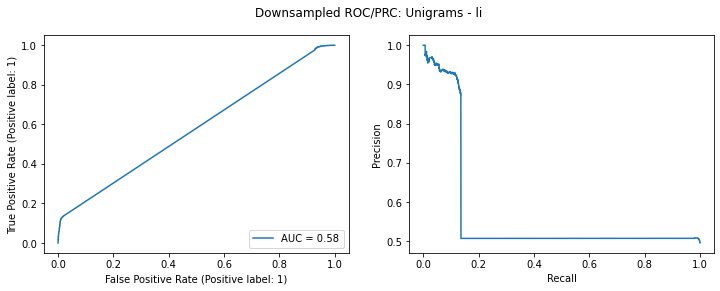

---------- lk ----------
Currently Stemming...
Preprocessing Complete.
6830
[[1641 3679]
 [ 882 4323]] 

Accuracy: 0.5666508313539192
Cohen Kappa score: 0.13820350859933483
Sensitivity/Recall: 0.831
Specificity: 0.308
Precision 0.54
F1 Score: 0.6546528356174754


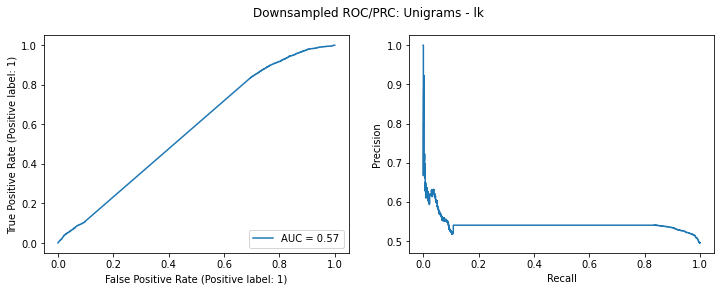

---------- ll ----------
Currently Stemming...
Preprocessing Complete.
2431
[[ 103 5217]
 [ 132 5073]] 

Accuracy: 0.4917814726840855
Cohen Kappa score: -0.005936642754816868
Sensitivity/Recall: 0.975
Specificity: 0.019
Precision 0.493
F1 Score: 0.6547918683446273


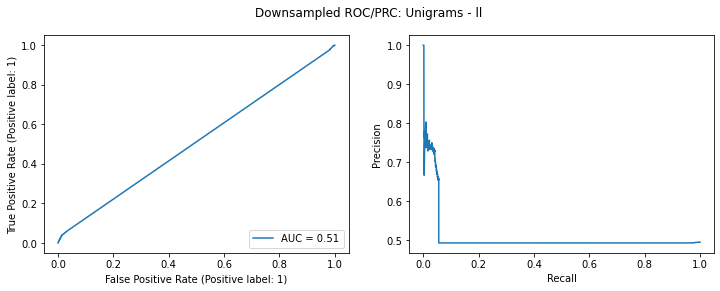

---------- pa ----------
Currently Stemming...
Preprocessing Complete.
1320
[[  75 5245]
 [  82 5123]] 

Accuracy: 0.49387173396674583
Cohen Kappa score: -0.0016387689170573871
Sensitivity/Recall: 0.984
Specificity: 0.014
Precision 0.494
F1 Score: 0.6579336030308867


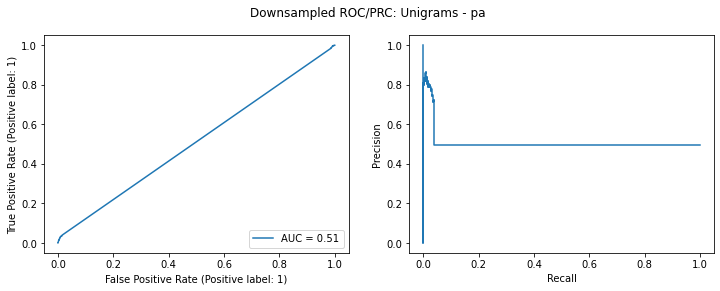

---------- rk ----------
Currently Stemming...
Preprocessing Complete.
6879
[[1680 3640]
 [ 857 4348]] 

Accuracy: 0.5727315914489312
Cohen Kappa score: 0.1502716860278437
Sensitivity/Recall: 0.835
Specificity: 0.316
Precision 0.544
F1 Score: 0.659137421359812


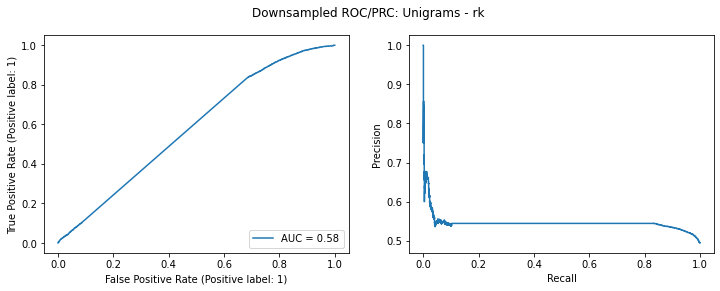

---------- rl ----------
Currently Stemming...
Preprocessing Complete.
2281
[[  88 5232]
 [ 104 5101]] 

Accuracy: 0.4930166270783848
Cohen Kappa score: -0.0034031958023914566
Sensitivity/Recall: 0.98
Specificity: 0.017
Precision 0.494
F1 Score: 0.6565838589265028


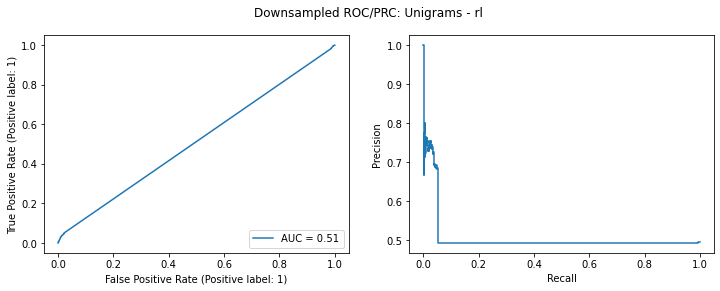

---------- sh ----------
Currently Stemming...
Preprocessing Complete.
80605
[[2237 3083]
 [1458 3747]] 

Accuracy: 0.5685510688836104
Cohen Kappa score: 0.13990137322554375
Sensitivity/Recall: 0.72
Specificity: 0.42
Precision 0.549
F1 Score: 0.6226838388034899


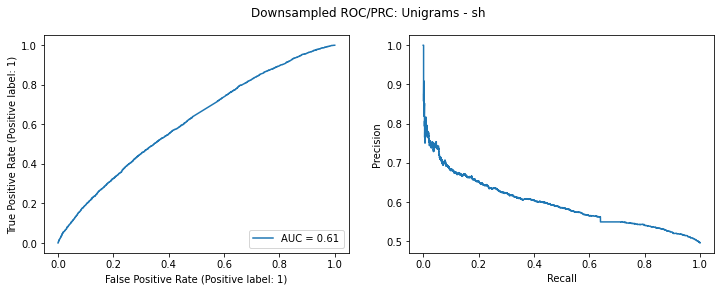

---------- tr ----------
Currently Stemming...
Preprocessing Complete.
3210
[[1013 4307]
 [ 932 4273]] 

Accuracy: 0.5022327790973872
Cohen Kappa score: 0.01127591198207989
Sensitivity/Recall: 0.821
Specificity: 0.19
Precision 0.498
F1 Score: 0.6199492201668482


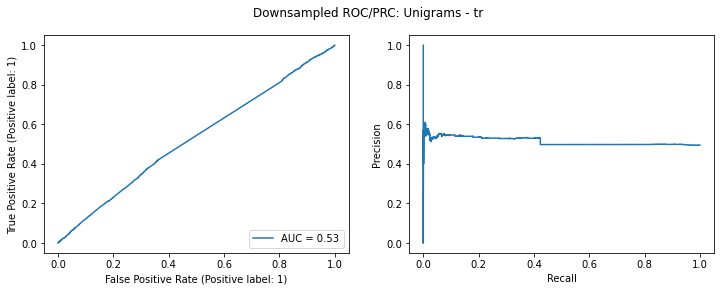

---------- ts ----------
Currently Stemming...
Preprocessing Complete.
684
[[  50 5270]
 [  58 5147]] 

Accuracy: 0.4937767220902613
Cohen Kappa score: -0.0017259556796305198
Sensitivity/Recall: 0.989
Specificity: 0.009
Precision 0.494
F1 Score: 0.658942516963257


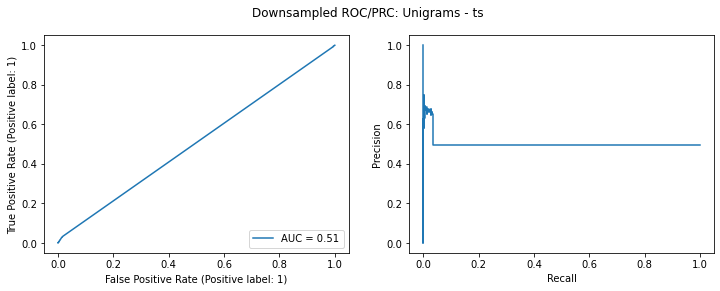

---------- vs ----------
Currently Stemming...
Preprocessing Complete.
2922
[[ 423 4897]
 [ 294 4911]] 

Accuracy: 0.506793349168646
Cohen Kappa score: 0.022809114094666905
Sensitivity/Recall: 0.944
Specificity: 0.08
Precision 0.501
F1 Score: 0.6542329980683408


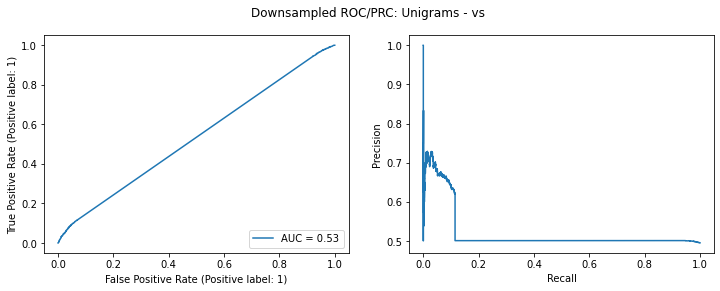

In [103]:
for x in data.columns[1:15]:
    print("----------", x, "----------")

    # select attributes
    data_new = select_attributes(data, [x])
    
    # Down sample
    y = np.asarray(data_new.utilization_boolean)
    X = np.asarray(data_new.drop('utilization_boolean', axis = 1))
    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X, y)
    data_new = pd.DataFrame({'utilization_boolean': y_res, 'text': [x[0]for x in X_res]})
    
    # set seed
    seed = 35

    # Test-train split
    X_train, X_test, y_train, y_test = train_test_split(data_new['text'], 
                                                        data_new['utilization_boolean'], 
                                                        random_state=seed)

    # Instantiate the TFIDF method
    tfidf = TfidfVectorizer(ngram_range=(1,1)) 

    # Fit the training data and then return the matrix
    training_data = tfidf.fit_transform(X_train)
    print("\nNum Unique Words",len(tfidf.vocabulary_.values()),"\n") # how many unique words do we have

    # Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
    testing_data = tfidf.transform(X_test)
    
    # Build models using 5-fold cv
    pipe_it_up = Pipeline([('clf', MultinomialNB())])
    param_grid = {'clf__alpha': [1, 1e-1, 1e-2]} # alpha = 1 is Laplace smoothing
    modelNB = GridSearchCV(pipe_it_up, param_grid, cv=5, scoring="accuracy")
    modelNB.fit(training_data, y_train)

    # evaluate model
    pred_probs = modelNB.predict_proba(testing_data)
    preds = modelNB.predict(testing_data)

    TN,FP,FN,TP = confusion_matrix(y_test, preds).ravel()

    print(confusion_matrix(y_test, preds),'\n')
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Cohen Kappa score:", cohen_kappa_score(y_test,preds))
    print("Sensitivity/Recall:", round(TP/(TP+FN),3))
    print("Specificity:", round(TN/(TN+FP),3))
    print("Precision", round(TP/(TP+FP),3))
    print("F1 Score:", f1_score(y_test, preds))

    # plot ROC
    fpr, tpr, thresh = roc_curve(y_test, pred_probs[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=roc_auc,pos_label=1) 

    # plot prc
    precision, recall, _ = precision_recall_curve(y_test, pred_probs[:,1], pos_label=1)
    pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)

    # show side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    plt.suptitle("Downsampled ROC/PRC: Unigrams - {}".format(x))
    plt.show()

---------- ac ----------
Currently Stemming...
Preprocessing Complete.

Num Unique Words 68220 

[[3294 2026]
 [1715 3490]] 

Accuracy: 0.6445605700712589
Cohen Kappa score: 0.289495103169219
Sensitivity/Recall: 0.671
Specificity: 0.619
Precision 0.633
F1 Score: 0.6510586699001958
---------- dh ----------
Currently Stemming...
Preprocessing Complete.

Num Unique Words 65948 

[[3221 2099]
 [1411 3794]] 

Accuracy: 0.6665083135391924
Cohen Kappa score: 0.3338886252369262
Sensitivity/Recall: 0.729
Specificity: 0.605
Precision 0.644
F1 Score: 0.6837267976211929
---------- lk ----------
Currently Stemming...
Preprocessing Complete.

Num Unique Words 6830 

[[1641 3679]
 [ 882 4323]] 

Accuracy: 0.5666508313539192
Cohen Kappa score: 0.13820350859933483
Sensitivity/Recall: 0.831
Specificity: 0.308
Precision 0.54
F1 Score: 0.6546528356174754
---------- rk ----------
Currently Stemming...
Preprocessing Complete.

Num Unique Words 6879 

[[1680 3640]
 [ 857 4348]] 

Accuracy: 0.5727315914489312

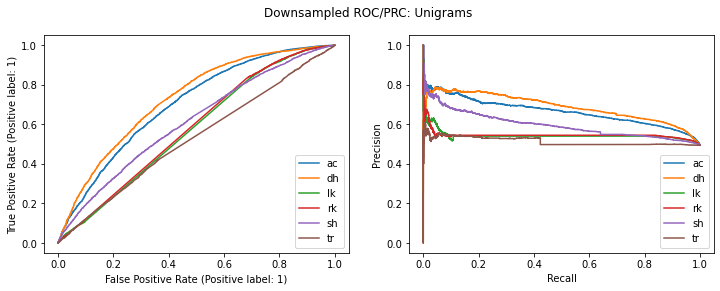

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))


for x in ["ac","dh","lk","rk","sh","tr"]:
    print("----------", x, "----------")

    # select attributes
    data_new = select_attributes(data, [x])
    
    # Down sample
    y = np.asarray(data_new.utilization_boolean)
    X = np.asarray(data_new.drop('utilization_boolean', axis = 1))
    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X, y)
    data_new = pd.DataFrame({'utilization_boolean': y_res, 'text': [x[0]for x in X_res]})
    
    # set seed
    seed = 35

    # Test-train split
    X_train, X_test, y_train, y_test = train_test_split(data_new['text'], 
                                                        data_new['utilization_boolean'], 
                                                        random_state=seed)

    # Instantiate the TFIDF method
    tfidf = TfidfVectorizer(ngram_range=(1,1)) 

    # Fit the training data and then return the matrix
    training_data = tfidf.fit_transform(X_train)
    print("\nNum Unique Words",len(tfidf.vocabulary_.values()),"\n") # how many unique words do we have

    # Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
    testing_data = tfidf.transform(X_test)
    
    # Build models using 5-fold cv
    pipe_it_up = Pipeline([('clf', MultinomialNB())])
    param_grid = {'clf__alpha': [1, 1e-1, 1e-2]} # alpha = 1 is Laplace smoothing
    modelNB = GridSearchCV(pipe_it_up, param_grid, cv=5, scoring="accuracy")
    modelNB.fit(training_data, y_train)

    # evaluate model
    pred_probs = modelNB.predict_proba(testing_data)
    preds = modelNB.predict(testing_data)

    TN,FP,FN,TP = confusion_matrix(y_test, preds).ravel()

    print(confusion_matrix(y_test, preds),'\n')
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Cohen Kappa score:", cohen_kappa_score(y_test,preds))
    print("Sensitivity/Recall:", round(TP/(TP+FN),3))
    print("Specificity:", round(TN/(TN+FP),3))
    print("Precision", round(TP/(TP+FP),3))
    print("F1 Score:", f1_score(y_test, preds))

    # store ROC
    fpr, tpr, thresh = roc_curve(y_test, pred_probs[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=roc_auc,pos_label=1) 

    # store prc
    precision, recall, _ = precision_recall_curve(y_test, pred_probs[:,1], pos_label=1)
    pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)

    # show side by side
    roc_display.plot(ax=ax1, label=x)
    pr_display.plot(ax=ax2, label=x)
    
plt.suptitle("Downsampled ROC/PRC: Unigrams")
plt.legend()
plt.show()

### Generate models that uses only the three most predictive text fields:

In [58]:
# select attributes based on results only using 3 of the most predictive text fields
# do NOT include diag test
data_new = select_attributes(data, ["ac","dh","sh"])
    
# Down sample
y = np.asarray(data_new.utilization_boolean)
X = np.asarray(data_new.drop('utilization_boolean', axis = 1))
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
data_new = pd.DataFrame({'utilization_boolean': y_res, 'text': [x[0]for x in X_res]})
    
# set seed
seed = 35

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(data_new['text'], 
                                                        data_new['utilization_boolean'], 
                                                        random_state=seed)

Currently Stemming...
Preprocessing Complete.


In [62]:
# Prepare models
models = []
models.append(('NB', 
               MultinomialNB(),
               {'clf__alpha': [1, 1e-1, 1e-2]}))

models.append(('LR', 
               LogisticRegression(random_state=42),
               {'clf__penalty': ['l1', 'l2', 'elasticnet', 'none']}))

models.append(('SGD',
               SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None),
              {'clf__penalty': ['l1', 'l2', 'elasticnet', 'none']}))

models.append(('SVC', 
               SVC(random_state = 42,probability=True),
               {'clf__C' :[2,4]}))

# models.append(('RF', RandomForestClassifier(n_estimators=400,
#                                             random_state=42),
#                {'clf__n_estimators' :[100,200,600],'clf__min_samples_split' : [2,4]}))



---------- NB ----------
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START clf__alpha=1................................................
[CV 1/5; 1/3] END .................clf__alpha=1;, score=0.702 total time=  17.0s
[CV 2/5; 1/3] START clf__alpha=1................................................
[CV 2/5; 1/3] END .................clf__alpha=1;, score=0.707 total time=  16.9s
[CV 3/5; 1/3] START clf__alpha=1................................................
[CV 3/5; 1/3] END .................clf__alpha=1;, score=0.703 total time=  17.0s
[CV 4/5; 1/3] START clf__alpha=1................................................
[CV 4/5; 1/3] END .................clf__alpha=1;, score=0.702 total time=  17.0s
[CV 5/5; 1/3] START clf__alpha=1................................................
[CV 5/5; 1/3] END .................clf__alpha=1;, score=0.695 total time=  17.0s
[CV 1/5; 2/3] START clf__alpha=0.1..............................................
[CV 1/5; 2/3] END ......

KeyboardInterrupt: 

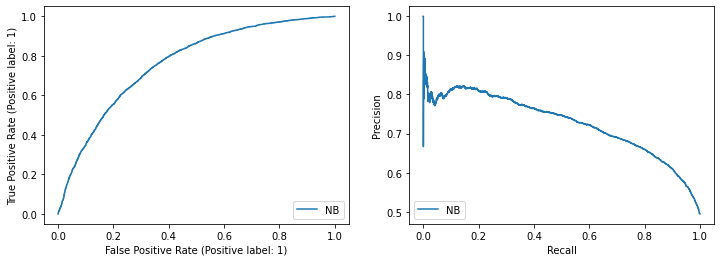

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for label, model, params in models:
    print("----------", label, "----------")
    pipe_it_up = Pipeline([
         ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
        ('clf', model)])
    
    start = time.time()
    
    modelNB = GridSearchCV(pipe_it_up, params, cv=5, scoring="accuracy", verbose=10)
    modelNB.fit(X_train, y_train)
    
    print("Time to fit:", time.time()-start)


    print("Best Parameters:",modelNB.best_params_)
    
    # evaluate model
    pred_probs = modelNB.predict_proba(X_test)
    preds = modelNB.predict(X_test)

    TN,FP,FN,TP = confusion_matrix(y_test, preds).ravel()

    print(confusion_matrix(y_test, preds),'\n')
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Cohen Kappa score:", cohen_kappa_score(y_test,preds))
    print("Sensitivity/Recall:", round(TP/(TP+FN),3))
    print("Specificity:", round(TN/(TN+FP),3))
    print("Precision", round(TP/(TP+FP),3))
    print("F1 Score:", f1_score(y_test, preds))

    # store roc
    fpr, tpr, thresh = roc_curve(y_test, pred_probs[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=roc_auc,pos_label=1) 

    # store prc
    precision, recall, _ = precision_recall_curve(y_test, pred_probs[:,1], pos_label=1)
    pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)

    # show side by side
    roc_display.plot(ax=ax1, label=label)
    pr_display.plot(ax=ax2, label=label)
    
plt.suptitle("Downsampled ROC/PRC: AC,DH,SH")
plt.legend()
plt.show()

### Generate models that uses only the three most predictive text fields AND diag_text field:

In [145]:
# select attributes based on results above
data_new = select_attributes(data, ["ac","dh","sh"],diag=True)
    
# Down sample
y = np.asarray(data_new.utilization_boolean)
X = np.asarray(data_new.drop('utilization_boolean', axis = 1))
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
data_new = pd.DataFrame({'utilization_boolean': y_res, 'text': [x[0]for x in X_res]})
    
# set seed
seed = 35

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(data_new['text'], 
                                                        data_new['utilization_boolean'], 
                                                        random_state=seed)

In [147]:
# Prepare models
models = []
models.append(('NB', 
               MultinomialNB(),
               {'clf__alpha': [1, 1e-1, 1e-2]}))

models.append(('LR', 
               LogisticRegression(random_state=42),
               {'clf__penalty': ['l1', 'l2', 'elasticnet', 'none']}))


models.append(('SGD',
               SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None),
              {'clf__penalty': ['l1', 'l2', 'elasticnet', 'none']}))

models.append(('SVC', 
               SVC(random_state = 42),
               {'clf__C' :[2,4]}))

# models.append(('RF', RandomForestClassifier(n_estimators=400,
#                                             random_state=42),
#                {'clf__n_estimators' :[100,200,600],'clf__min_samples_split' : [2,4]}))


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for label, model, params in models:
    print("----------", label, "----------")
    pipe_it_up = Pipeline([
         ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
        ('clf', model)])

    start = time.time()
    
    modelNB = GridSearchCV(pipe_it_up, params, cv=5, scoring="accuracy", verbose=10)
    modelNB.fit(X_train, y_train)
    
    print("Time to fit:", time.time()-start)


    print("Best Parameters:",modelNB.best_params_)

    # evaluate model
    pred_probs = modelNB.predict_proba(X_test)
    preds = modelNB.predict(X_test)

    TN,FP,FN,TP = confusion_matrix(y_test, preds).ravel()

    print(confusion_matrix(y_test, preds),'\n')
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Cohen Kappa score:", cohen_kappa_score(y_test,preds))
    print("Sensitivity/Recall:", round(TP/(TP+FN),3))
    print("Specificity:", round(TN/(TN+FP),3))
    print("Precision", round(TP/(TP+FP),3))
    print("F1 Score:", f1_score(y_test, preds))

    # store roc
    fpr, tpr, thresh = roc_curve(y_test, pred_probs[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=roc_auc,pos_label=1) 

    # store prc
    precision, recall, _ = precision_recall_curve(y_test, pred_probs[:,1], pos_label=1)
    pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)

    # show side by side
    roc_display.plot(ax=ax1, label=label)
    pr_display.plot(ax=ax2, label=label)
    
plt.suptitle("Downsampled ROC/PRC: ac,dh,sh & diag tests")
plt.legend()
plt.show()

---------- NB ----------
[[3107 2213]
 [ 973 4232]] 

Accuracy: 0.69729216152019
Cohen Kappa score: 0.3960670919497584
Sensitivity/Recall: 0.813
Specificity: 0.584
Precision 0.657
F1 Score: 0.7265236051502146
---------- LR ----------


### Try running with all data but use the class weights option instead of downsampling

Currently Stemming...
Preprocessing Complete.
---------- RF ----------
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START clf__min_samples_split=2....................................
[CV 1/5; 1/2] END .....clf__min_samples_split=2;, score=0.517 total time=17.6min
[CV 2/5; 1/2] START clf__min_samples_split=2....................................
[CV 2/5; 1/2] END .....clf__min_samples_split=2;, score=0.517 total time=17.3min
[CV 3/5; 1/2] START clf__min_samples_split=2....................................
[CV 3/5; 1/2] END .....clf__min_samples_split=2;, score=0.519 total time=17.5min
[CV 4/5; 1/2] START clf__min_samples_split=2....................................
[CV 4/5; 1/2] END .....clf__min_samples_split=2;, score=0.519 total time=17.3min
[CV 5/5; 1/2] START clf__min_samples_split=2....................................
[CV 5/5; 1/2] END .....clf__min_samples_split=2;, score=0.518 total time=17.4min
[CV 1/5; 2/2] START clf__min_samples_split=4...............

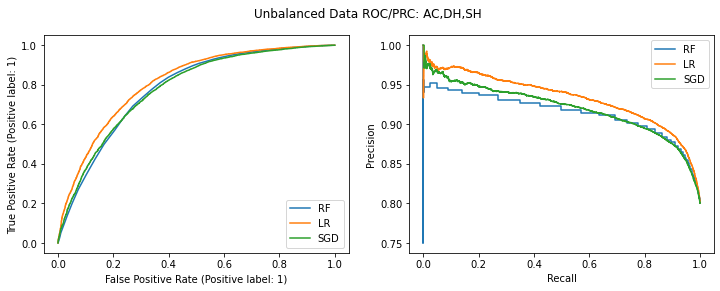

In [7]:
#data_new = select_attributes(data, ["ac","dh","sh"],diag=True)
data_new = select_attributes(data, ["ac","dh","sh"])

 
# set seed
seed = 35

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(data_new['text'], 
                                                        data_new['utilization_boolean'], 
                                                        random_state=seed)
# Prepare models
models = []
models.append(('GBoost', 
               GradientBoostingClassifier(random_state=42, class_weight="balanced"),
               {'clf__C': [.1,1,10]}))

models.append(('RF', RandomForestClassifier(n_estimators=100,
                                            random_state=42),
               {'clf__min_samples_split' : [2,4]}))

models.append(('LR', 
               LogisticRegression(random_state=42, penalty = 'l2', class_weight="balanced"),
               {'clf__C': [.1,1,10]}))

models.append(('SGD',
               SGDClassifier(loss='log', class_weight="balanced",
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None),
              {'clf__penalty': ['l1', 'l2', 'elasticnet', 'none']}))


# takes so long it never worked
# models.append(('SVC', 
#                SVC(random_state = 42,class_weight='balanced',probability=True),
#                {'clf__C' :[2,4]}))



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for label, model, params in models:
    print("----------", label, "----------")
    pipe_it_up = Pipeline([
         ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
        ('clf', model)])

    start = time.time()
    
    modelNB = GridSearchCV(pipe_it_up, params, cv=5, scoring="balanced_accuracy", verbose=10)
    modelNB.fit(X_train, y_train)
    
    print("\nTime to fit:", time.time()-start)


    print("\nBest Parameters:",modelNB.best_params_)

    # evaluate model
    pred_probs = modelNB.predict_proba(X_test)
    preds = modelNB.predict(X_test)

    TN,FP,FN,TP = confusion_matrix(y_test, preds).ravel()

    print(confusion_matrix(y_test, preds),'\n')
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Cohen Kappa score:", cohen_kappa_score(y_test,preds))
    print("Sensitivity/Recall:", round(TP/(TP+FN),3))
    print("Specificity:", round(TN/(TN+FP),3))
    print("Precision", round(TP/(TP+FP),3))
    print("F1 Score:", f1_score(y_test, preds))
    
    # store roc
    fpr, tpr, thresh = roc_curve(y_test, pred_probs[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=roc_auc,pos_label=1) 

    # store prc
    precision, recall, _ = precision_recall_curve(y_test, pred_probs[:,1], pos_label=1)
    pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)

    # show side by side
    roc_display.plot(ax=ax1, label=label)
    pr_display.plot(ax=ax2, label=label)
    
plt.suptitle("Unbalanced Data ROC/PRC: AC,DH,SH")
plt.legend()
plt.show()

# Use an ensemble method to resolve the data imbalance
Right now, including all the data we have, we have a class imbalance of 80% / 20%. I am first going to split the stemmed data into a test and training dataset.

In [17]:
#data_new = select_attributes(data, ["ac","dh","sh"])
data_new.shape

(104607, 2)

In [18]:
data_new.head()

,utilization_boolean,text
0,1,yr femal smoke spice min onset seizur becam un...
1,1,pt found unrespons road sign head trauma repor...
2,1,year old male victim drive shoot sustain gsw h...
3,0,pt yo aam histori al in wheelchair home htn pt...
4,1,yo femal past medic histori alcohol opiat coca...


In [19]:
seed=10
# Test-train split
X_train, X_test, y_train, y_test = train_test_split(data_new['text'], 
                                                        data_new['utilization_boolean'], 
                                                        random_state=seed)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                        y_train, 
                                                        random_state=seed+1)
print("Number of Training Samples", X_train.shape)
print(y_train.value_counts(normalize=True))
print("Number of Validation Samples", X_valid.shape)
print(y_valid.value_counts(normalize=True))
print("Number of Testing Samples", X_test.shape)
print(y_test.value_counts(normalize=True))

Number of Training Samples (58841,)
1    0.798848
0    0.201152
Name: utilization_boolean, dtype: float64
Number of Validation Samples (19614,)
1    0.796217
0    0.203783
Name: utilization_boolean, dtype: float64
Number of Testing Samples (26152,)
1    0.800551
0    0.199449
Name: utilization_boolean, dtype: float64


Now, I want to split the training dataset into 5 different models of balanced observations to build 5 models to ensemble together. Effectively, we are up-sampling the minority class but building separate models. 

In [20]:
from sklearn.utils import shuffle

# collect the training samples to be in all the 
mask = y_train==0
# get the training data with minority labels to be added to every set
X_train_0s = X_train[mask]
y_train_0s = y_train[mask]
minority_df = pd.DataFrame({'text':X_train_0s,'utilization_boolean':y_train_0s})

# get training data with majority class
X_train_1s = X_train[-mask]
y_train_1s = y_train[-mask]

# define function to partition majority class dataset into 
def partition (list_in, n):
    shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

partitions = partition(X_train_1s.index, 4)


df0 = pd.DataFrame({'text':X_train_1s[partitions[0]], \
                    'utilization_boolean':y_train_1s[partitions[0]]}).append(minority_df)
print(df0.utilization_boolean.value_counts(normalize=True))

df1 = pd.DataFrame({'text':X_train_1s[partitions[1]], \
                    'utilization_boolean':y_train_1s[partitions[1]]}).append(minority_df)
print(df1.utilization_boolean.value_counts(normalize=True))

df2 = pd.DataFrame({'text':X_train_1s[partitions[2]], \
                    'utilization_boolean':y_train_1s[partitions[2]]}).append(minority_df)
print(df2.utilization_boolean.value_counts(normalize=True))

df3 = pd.DataFrame({'text':X_train_1s[partitions[3]], \
                    'utilization_boolean':y_train_1s[partitions[3]]}).append(minority_df)
print(df3.utilization_boolean.value_counts(normalize=True))

0    0.501781
1    0.498219
Name: utilization_boolean, dtype: float64
0    0.501802
1    0.498198
Name: utilization_boolean, dtype: float64
0    0.501802
1    0.498198
Name: utilization_boolean, dtype: float64
0    0.501802
1    0.498198
Name: utilization_boolean, dtype: float64


In [21]:
# make sure to shuffle 
df0=shuffle(df0, random_state=52)
df1=shuffle(df1, random_state=52)
df2=shuffle(df2, random_state=52)
df3=shuffle(df3, random_state=52)
df0.head()

,text,utilization_boolean
54788,pt cf admit norh ed via em w cardiac arrest se...,0
26607,pt call sob em found pea rosc minut ed went vf...,1
84377,yo hf kg aadmit jump move car unabl intub scen...,1
9780,pt adm sp mva unrestrain driver lost control c...,1
32731,pt origin admit osh fever abdomin pain diagnos...,0


In [22]:
pipe_it_up = Pipeline([
         ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
        ('clf', LogisticRegression(random_state=42,penalty='l2'))])

params = {'clf__C': [0.1,1,10]}
model = GridSearchCV(pipe_it_up, params, cv=5, scoring="accuracy", verbose=10)
mod0 = model.fit(df0.text, df0.utilization_boolean)
mod1 = model.fit(df1.text, df1.utilization_boolean)
mod2 = model.fit(df2.text, df2.utilization_boolean)
mod3 = model.fit(df3.text, df3.utilization_boolean)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START clf__C=0.1..................................................
[CV 1/5; 1/3] END ...................clf__C=0.1;, score=0.693 total time=  22.6s
[CV 2/5; 1/3] START clf__C=0.1..................................................
[CV 2/5; 1/3] END ...................clf__C=0.1;, score=0.707 total time=  16.8s
[CV 3/5; 1/3] START clf__C=0.1..................................................
[CV 3/5; 1/3] END ...................clf__C=0.1;, score=0.713 total time=  17.3s
[CV 4/5; 1/3] START clf__C=0.1..................................................
[CV 4/5; 1/3] END ...................clf__C=0.1;, score=0.700 total time=  20.6s
[CV 5/5; 1/3] START clf__C=0.1..................................................
[CV 5/5; 1/3] END ...................clf__C=0.1;, score=0.696 total time=  22.3s
[CV 1/5; 2/3] START clf__C=1....................................................
[CV 1/5; 2/3] END .....................clf__C=1;,

#### Voting classifier

In [28]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

In [25]:
estimators = [('mod0', mod0), ('mod1', mod1), ('mod2', mod2),('mod3', mod3)]
eclf = VotingClassifier(estimators=estimators,
                        voting='soft')
eclf.fit(X_train, y_train).score(X_valid, y_valid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START clf__C=0.1..................................................
[CV 1/5; 1/3] END ...................clf__C=0.1;, score=0.800 total time=  47.9s
[CV 2/5; 1/3] START clf__C=0.1..................................................


KeyboardInterrupt: 

#### Stacking model

In [29]:
sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
sclf.fit(X_valid, y_valid).score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START clf__C=0.1..................................................


KeyboardInterrupt: 

# Consider adding other (clinical) features

In [ ]:
don_text_vars = ["ac","dh","sh"]
don_clinic_vars = ["donor_age","dcd_donor","opo"]
temp = data[["utilization_boolean"]+don_text_vars+don_clinic_vars]
    
# combine attributes into a list
temp["text"] = temp.apply(lambda x: str([x[i] for i in temp.columns[1:] if x[i] is not np.NaN]),axis=1)
temp.drop(don_text_vars,axis=1, inplace=True)
    
# remove stop words, lowercase
temp['new_col']=temp["text"].apply(lambda x: \
                        ' '.join([word for word in x.lower().split() if word not in (stop)]))
# remove punctuation
temp["new_text"] = temp['new_col'].str.replace('[^\sa-z]','')
temp.drop(["text","new_col"], axis=1, inplace=True)
    

temp["text"] = temp["new_text"].apply(\
                            lambda x: [PorterStemmer().stem(w) for w in word_tokenize(x)])
temp = temp.drop(["new_text"],axis=1)
temp["text"] = temp["text"].apply(lambda x: " ".join(x))

# Model Building - Word Embeddings & Deep Learning Classification Methods

In [3]:
data = pd.read_csv('df0_for_miguel.csv')
data.drop('Unnamed: 0', axis = 1, inplace = True)
data.columns = ['text', 'label']
data.head()

,text,label
0,pt cf admit norh ed via em w cardiac arrest se...,0
1,pt call sob em found pea rosc minut ed went vf...,1
2,yo hf kg aadmit jump move car unabl intub scen...,1
3,pt adm sp mva unrestrain driver lost control c...,1
4,pt origin admit osh fever abdomin pain diagnos...,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.label)
train_text = pd.Series(X_train.to_numpy())
token = Tokenizer(num_words = 100000, oov_token = 'unknown')
token.fit_on_texts(train_text)
token.word_index['<pad>'] = 0
token.index_word[0] = '<pad>'
train_seqs = token.texts_to_sequences(train_text)
train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
train_labels = y_train.to_numpy().flatten()
test_text = pd.Series(X_test.to_numpy())
test_seqs = token.texts_to_sequences(test_text)
test_seqs = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')
test_labels = y_test.to_numpy().flatten()
train_ds = tf.data.Dataset.from_tensor_slices((train_seqs,train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_seqs,test_labels))
train_ds = train_ds.shuffle(1000).batch(32).prefetch(1)
test_ds = test_ds.batch(32).prefetch(1)

In [7]:
embed_size = 2000
vocab_size = 100000
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embed_size),
    keras.layers.GRU(2000),
    keras.layers.Dense(1, activation = 'sigmoid')
])
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(train_ds.take(10), epochs = 5)

Epoch 1/5
10/10 [==============================] - 153s 15s/step - loss: 0.8550 - accuracy: 0.4938
Epoch 2/5
10/10 [==============================] - 154s 15s/step - loss: 0.6988 - accuracy: 0.4875
Epoch 3/5


KeyboardInterrupt: 